# Regressão logística Multinomial
## Analisando a eficácia das vacinas Covid 19 entre diferentes faixas etárias utilizando o modelo de regressão multinomial

### Regressão Logística:

A regressão logística é um algoritmo de classificação binária usado quando a variável dependente é categórica e possui duas classes. Ele modela a probabilidade de uma instância pertencer a uma classe específica.

Na regressão logística binária, a saída do modelo é transformada usando a função logística (função sigmóide), que garante que os valores previstos fiquem entre 0 e 1. O limite de decisão é definido em 0,5 e as instâncias são classificadas com base em se a probabilidade prevista é acima ou abaixo deste limite.

### Regressão Multinomial:

A regressão logística multinomial estende a regressão logística binária para lidar com várias classes. Em vez de prever um resultado binário, prevê a probabilidade de uma instância pertencer a cada classe. A função softmax é usada para transformar a saída bruta do modelo em uma distribuição de probabilidade em várias classes.

Aqui estão os principais componentes da regressão logística multinomial:

1. **Saída do modelo:**
    - Para cada classe, o modelo produz um conjunto separado de coeficientes.
    - A função softmax converte as pontuações brutas (logits) em probabilidades, garantindo que a soma das probabilidades seja 1 em todas as classes.

2. **Regra de decisão:**
    - A classe com maior probabilidade é escolhida como a classe prevista para uma determinada instância.

3. **Parâmetros:**
    - O modelo é treinado para aprender um conjunto de parâmetros (coeficientes) que maximizam a probabilidade dos dados observados.

4. **Função de perda:**
    - A função de perda de entropia cruzada é comumente usada para treinar modelos de regressão logística multinomial. Ele mede a diferença entre as probabilidades previstas e os rótulos reais das classes.


### Exemplos práticos:

A regressão logística multinomial é adequada para cenários onde há mais de duas classes e as classes são mutuamente exclusivas. Exemplos incluem:
- Prever o tipo de fruta (por exemplo, maçã, laranja, banana) com base em determinadas características.
- Prever o resultado de um diagnóstico médico (por exemplo, saudável, leve, grave).

```python
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
```

No geral, a regressão logística multinomial é um algoritmo fundamental para problemas de classificação multiclasse e serve como um alicerce para modelos mais complexos em aprendizado de máquina.

Carregando as bibliotecas

In [23]:
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.stats import chi2
import scipy.stats as stats
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import warnings

# Suprimir warnings específicos
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [24]:
dados = pd.read_excel('dados_covid19_vacinas.xlsx')

# Entendimento da Base de dados


 **Date:**
Data em que as observações foram registradas. Intervalo de registros compreendido entre: 2021-09-05 e 2021-12-31.

**Idade_agrupamento:**
Variavel categórica que agrupa a idade dos individuos infectados com COVID

| Age Group | Category |
|-----------|----------|
| 1         | 0-19     |
| 2         | 19-29    |
| 3         | 29-39    |
| 4         | 39-49    |
| 5         | 49-59    |
| 6         | 59-69    |
| 7         | 69-79    |
| 8         | 79-80+   |

 **nao_vacinados:** Nº de pessoas que foram infectadas com o COVID-19 e  não receberam nenhuma dose de vacina

**vacinados_parcialmente:** Nº de pessoas que foram infectadas com o COVID-19 e receberam pelo menos uma dose da vacina, mas nao estavam totalmente vacinados.

**totalmente_vacinados:** Nº de pessoas que foram infectadas com o COVID-19 e estavam totalmente vacinados.

Em resumo, o conjunto de dados captura informações sobre casos de COVID-19 com base em faixas etárias e estado de vacinação em uma data específica. As variáveis incluem a data de observação, a categorização da faixa etária e o número de casos de indivíduos não vacinados, parcialmente vacinados e totalmente vacinados dentro de cada faixa etária.

Visualizando os dados carregados

In [25]:
dados.head()

,Date,idade_agrupamento,nao_vacinados,vacinados_parcialmente,totalmente_vacinados
0,2021-09-05,1,98,7,0
1,2021-09-05,2,63,12,9
2,2021-09-05,3,50,4,11
3,2021-09-05,4,28,3,9
4,2021-09-05,5,29,0,9


Validação da base de dados

In [26]:
dados.columns

Index(['Date', 'idade_agrupamento', 'nao_vacinados', 'vacinados_parcialmente',
       'totalmente_vacinados'],
      dtype='object')

In [27]:
dados.shape

(936, 5)

In [28]:
dados.describe()

,Date,idade_agrupamento
count,936,936.000000
mean,2021-11-02 21:20:00,4.500000
min,2021-09-05 00:00:00,1.000000
25%,2021-10-05 00:00:00,2.750000
50%,2021-11-03 00:00:00,4.500000
75%,2021-12-02 00:00:00,6.250000
max,2021-12-31 00:00:00,8.000000
std,NaN,2.292513


In [29]:
dados.dtypes

Date                      datetime64[ns]
idade_agrupamento                  int64
nao_vacinados                     object
vacinados_parcialmente            object
totalmente_vacinados              object
dtype: object

**Tratamento de Dados**

In [30]:
relevant_columns = ['nao_vacinados', 'vacinados_parcialmente', 'totalmente_vacinados']

Converter as colunas em numérico

In [31]:
dados[relevant_columns] = dados[relevant_columns].apply(pd.to_numeric, errors='coerce')

Preencher os dados ausentes com a média

In [32]:
dados[relevant_columns] = dados[relevant_columns].fillna(dados[relevant_columns].mean())

Verificar a quantidade de linhas na variável idade_agrupamento

In [33]:
print("Quantidade de linhas na variável idade_agrupamento:", dados['idade_agrupamento'].shape[0])

Quantidade de linhas na variável idade_agrupamento: 936


Preencher os dados ausentes na variável idade_agrupamento com o valor mais frequente

In [34]:
idade_agrupamento_mode = dados['idade_agrupamento'].mode()[0]
dados['idade_agrupamento'].fillna(idade_agrupamento_mode, inplace=True)

Verificar o número de linhas da variável de resposta e da matriz de variáveis explicativas

In [35]:
y = dados['idade_agrupamento']
X = dados[['nao_vacinados', 'vacinados_parcialmente', 'totalmente_vacinados']]
print("Número de linhas da variável de resposta:", y.shape[0])
print("Número de linhas da matriz de variáveis explicativas:", X.shape[0])

Número de linhas da variável de resposta: 936
Número de linhas da matriz de variáveis explicativas: 936


In [36]:
dados.describe()

,Date,idade_agrupamento,nao_vacinados,vacinados_parcialmente,totalmente_vacinados
count,936,936.000000,936.000000,936.000000,936.000000
mean,2021-11-02 21:20:00,4.500000,23.004301,1.149451,6.425668
min,2021-09-05 00:00:00,1.000000,0.000000,0.000000,0.000000
25%,2021-10-05 00:00:00,2.750000,3.750000,0.000000,2.000000
50%,2021-11-03 00:00:00,4.500000,10.000000,0.000000,5.000000
75%,2021-12-02 00:00:00,6.250000,28.000000,2.000000,8.000000
max,2021-12-31 00:00:00,8.000000,240.000000,13.000000,94.000000
std,NaN,2.292513,33.041604,1.789953,6.860924


In [37]:
dados

,Date,idade_agrupamento,nao_vacinados,vacinados_parcialmente,totalmente_vacinados
0,2021-09-05,1,98.0,7.0,0.0
1,2021-09-05,2,63.0,12.0,9.0
2,2021-09-05,3,50.0,4.0,11.0
3,2021-09-05,4,28.0,3.0,9.0
4,2021-09-05,5,29.0,0.0,9.0
...,...,...,...,...,...
931,2021-12-31,4,70.0,0.0,42.0
932,2021-12-31,5,51.0,0.0,24.0
933,2021-12-31,6,35.0,0.0,9.0
934,2021-12-31,7,6.0,0.0,7.0


In [38]:
variaveis = dados[['idade_agrupamento', 'nao_vacinados', 'vacinados_parcialmente', 'totalmente_vacinados']]

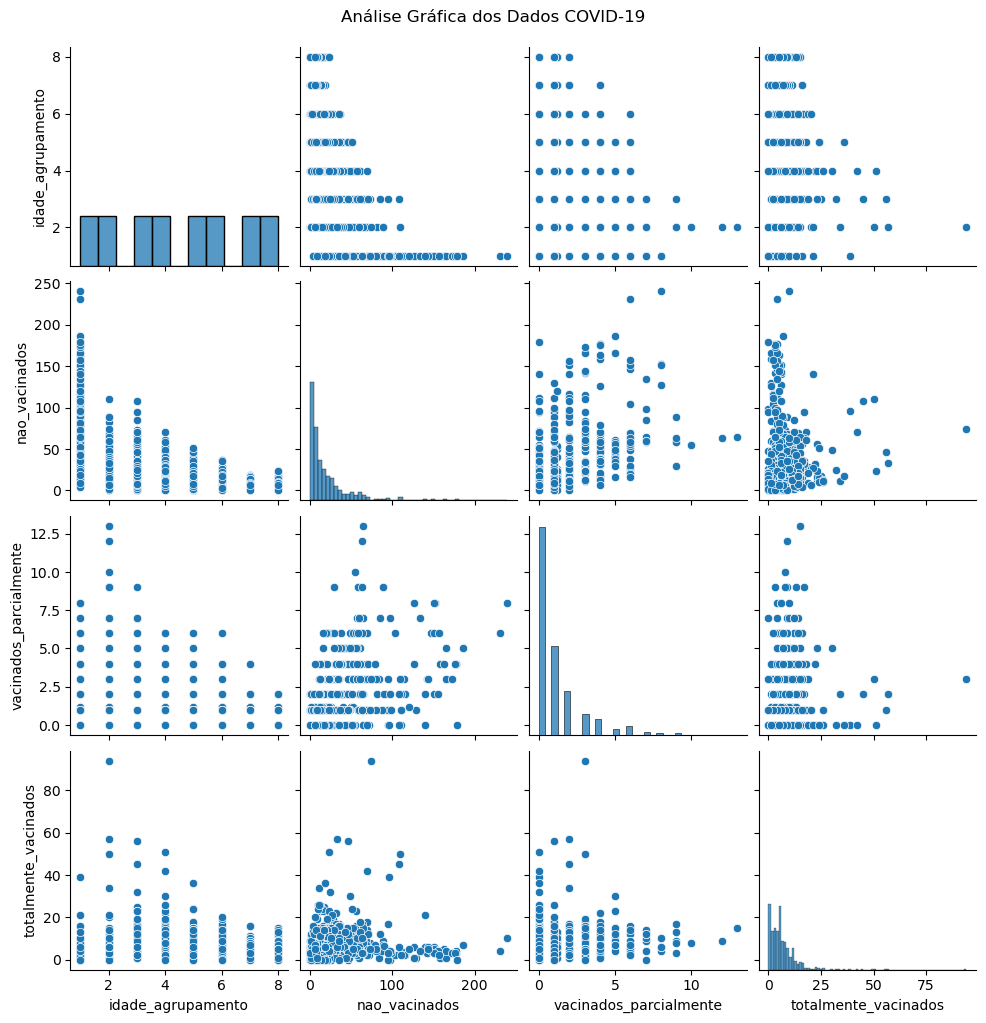

In [39]:
# Análise gráfica - Pairplot
import seaborn as sns
sns.pairplot(variaveis)
plt.suptitle("Análise Gráfica dos Dados COVID-19", y=1.02)
plt.show()

In [40]:
variaveis.corr()

,idade_agrupamento,nao_vacinados,vacinados_parcialmente,totalmente_vacinados
idade_agrupamento,1.000000,-0.537975,-0.377692,-0.149968
nao_vacinados,-0.537975,1.000000,0.564211,0.172234
vacinados_parcialmente,-0.377692,0.564211,1.000000,0.209882
totalmente_vacinados,-0.149968,0.172234,0.209882,1.000000


Criando o Modelo 

In [41]:
y = dados['idade_agrupamento']
X = dados[['nao_vacinados', 'vacinados_parcialmente', 'totalmente_vacinados']]

Dividir os dados em conjuntos de treinamento e teste

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Verificar o tamanho de cada conjunto de dados

In [43]:
print("Tamanho do conjunto de treinamento (X_train):", X_train.shape)
print("Tamanho do conjunto de teste (X_test):", X_test.shape)
print("Tamanho do conjunto de treinamento (y_train):", y_train.shape)
print("Tamanho do conjunto de teste (y_test):", y_test.shape)

Tamanho do conjunto de treinamento (X_train): (748, 3)
Tamanho do conjunto de teste (X_test): (188, 3)
Tamanho do conjunto de treinamento (y_train): (748,)
Tamanho do conjunto de teste (y_test): (188,)


In [44]:
# Ajustar o modelo de regressão logística multinomial usando statsmodels
model = sm.MNLogit(y_train, sm.add_constant(X_train))
results = model.fit()

# Resumo do modelo
print(results.summary())

Optimization terminated successfully.
         Current function value: 1.679980
         Iterations 8
                          MNLogit Regression Results                          
Dep. Variable:      idade_agrupamento   No. Observations:                  748
Model:                        MNLogit   Df Residuals:                      720
Method:                           MLE   Df Model:                           21
Date:                Mon, 03 Mar 2025   Pseudo R-squ.:                  0.1916
Time:                        18:54:51   Log-Likelihood:                -1256.6
converged:                       True   LL-Null:                       -1554.4
Covariance Type:            nonrobust   LLR p-value:                1.396e-112
   idade_agrupamento=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.4551      0.356      1.280      0.201      -0.242      

### Verificando os pressupostos

In [45]:
# Obter probabilidades previstas
probabilidades_previstas = results.predict()

### Deviance Residuals

**Hipótese Testada:**

-   $H_0$: O modelo ajusta bem os dados.

-   $H_a$: O modelo não ajusta bem os dados.

**Condição de Aceitação/Rejeição:**

-   A deviance total é comparada com uma distribuição qui-quadrado com $n - p$ graus de liberdade, onde $n$ é o número de observações e $p$ é o número de parâmetros no modelo.

-   **Aceitação de** $H_0$: Se o valor $p$ calculado a partir da deviance é maior que $\alpha$, aceitamos $H_0$ e concluímos que o modelo ajusta bem os dados.

-   **Rejeição de** $H_0$: Se o valor $p$ é menor que $\alpha$, rejeitamos $H_0$ e concluímos que o modelo não ajusta bem os dados.


In [46]:
# Resíduos: calcular resíduos deviance manualmente
def residuos_deviance(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-10, 1 - 1e-10)  # Evitar log(0)
    deviance_residuals = 2 * (y_true * np.log(y_true / y_pred))
    deviance_residuals[np.isnan(deviance_residuals)] = 0  # Substituir NaNs por 0
    return np.sum(deviance_residuals)  # Retorna a soma para cada classe

In [47]:
# One-hot encoding para y_train
y_train_onehot = pd.get_dummies(y_train).values

In [48]:
# Criar lista para armazenar deviances por classe
deviances_por_classe = []

In [49]:
print("\n--- Deviance e p-valor por modelo ---")
# Calcular deviance e p-valor separadamente para cada modelo gerado
for i in range(y_train_onehot.shape[1]):  # Garantindo que os índices sejam válidos
    deviance_classe = residuos_deviance(y_train_onehot[:, i], probabilidades_previstas[:, i])
    p_value_classe = chi2.sf(deviance_classe, results.df_resid)  # Cálculo do p-valor
    
    deviances_por_classe.append(deviance_classe)
    classe = y_train.unique()[i]  # Pegar o rótulo correto da classe
    print(f"Classe: {classe} | Deviance: {deviance_classe:.4f} | p-value: {p_value_classe:.4f}")


--- Deviance e p-valor por modelo ---
Classe: 6 | Deviance: 145.0598 | p-value: 1.0000
Classe: 7 | Deviance: 372.4354 | p-value: 1.0000
Classe: 4 | Deviance: 324.1047 | p-value: 1.0000
Classe: 1 | Deviance: 349.4361 | p-value: 1.0000
Classe: 2 | Deviance: 371.5344 | p-value: 1.0000
Classe: 5 | Deviance: 351.2182 | p-value: 1.0000
Classe: 3 | Deviance: 287.0295 | p-value: 1.0000
Classe: 8 | Deviance: 312.4320 | p-value: 1.0000


C:\Users\gabri\AppData\Local\Temp\ipykernel_1892\3685555478.py:4: RuntimeWarning: divide by zero encountered in log
  deviance_residuals = 2 * (y_true * np.log(y_true / y_pred))
C:\Users\gabri\AppData\Local\Temp\ipykernel_1892\3685555478.py:4: RuntimeWarning: invalid value encountered in multiply
  deviance_residuals = 2 * (y_true * np.log(y_true / y_pred))


## Testes de adequação do modelo

### 1. Pearson Chi-Square Test

**Hipótese Testada:**

-   $H_0$: O modelo ajusta bem os dados.

-   $H_a$: O modelo não ajusta bem os dados.

**Condição de Aceitação/Rejeição:**

-   Calcula-se a estatística do teste qui-quadrado de Pearson, que segue uma distribuição qui-quadrado com $n - p$ graus de liberdade.

-   **Aceitação de** $H_0$: Se o valor $p$ é maior que $\alpha$, aceitamos $H_0$ e concluímos que o modelo ajusta bem os dados.

-   **Rejeição de** $H_0$: Se o valor $p$ é menor que $\alpha$, rejeitamos $H_0$ e concluímos que o modelo não ajusta bem os dados.

In [50]:
# Definir função para resíduos de Pearson
def residuos_pearson(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-10, 1 - 1e-10)  # Evitar divisão por zero
    return (y_true - y_pred) / np.sqrt(y_pred * (1 - y_pred))

In [51]:
# Criar lista para armazenar chi-quadrado por classe
chi2_por_classe = []

print("\n--- Teste Qui-Quadrado de Pearson por Modelo ---")
for i in range(y_train_onehot.shape[1]):  # Garantir que os índices sejam compatíveis
    residuos_pearson_val = residuos_pearson(y_train_onehot[:, i], probabilidades_previstas[:, i])
    chi2_classe = np.sum(residuos_pearson_val ** 2)  # Calcular qui-quadrado
    p_value_classe = round(chi2.sf(chi2_classe, results.df_resid), 4)   # Calcular p-valor
    
    chi2_por_classe.append(chi2_classe)
    
    classe = y_train.unique()[i]  # Pegar o rótulo correto da classe
    print(f"Classe: {classe} | Chi2: {chi2_classe:.4f} | p-value: {p_value_classe:.4f}")


--- Teste Qui-Quadrado de Pearson por Modelo ---
Classe: 6 | Chi2: 863.6407 | p-value: 0.0002
Classe: 7 | Chi2: 1887.8117 | p-value: 0.0000
Classe: 4 | Chi2: 704.2007 | p-value: 0.6561
Classe: 1 | Chi2: 657.5766 | p-value: 0.9533
Classe: 2 | Chi2: 660.2647 | p-value: 0.9454
Classe: 5 | Chi2: 622.3268 | p-value: 0.9963
Classe: 3 | Chi2: 632.8609 | p-value: 0.9913
Classe: 8 | Chi2: 628.5803 | p-value: 0.9938


### Teste de Hosmer-Lemeshow

**Hipótese Testada:**

-   $H_0$: O modelo ajusta bem os dados (não há diferença significativa entre as frequências observadas e esperadas).

-   $H_a$: O modelo não ajusta bem os dados (há diferença significativa entre as frequências observadas e esperadas).

**Condição de Aceitação/Rejeição:**

-   Calcula-se a estatística do teste de Hosmer-Lemeshow, que segue uma distribuição qui-quadrado com $g - 2$ graus de liberdade, onde $g$ é o número de grupos.

-   **Aceitação de** $H_0$: Se o valor $p$ é maior que o nível de significância $\alpha$ (geralmente 0.05), aceitamos $H_0$ e concluímos que o modelo ajusta bem os dados.

-   **Rejeição de** $H_0$: Se o valor $p$ é menor que $\alpha$, rejeitamos $H_0$ e concluímos que o modelo não ajusta bem os dados.

In [52]:
# Definir função para o teste de Hosmer-Lemeshow
def hosmer_lemeshow_test(y_true, y_pred, g=10):
    # Garantir que y_true e y_pred tenham pelo menos duas dimensões
    y_true = np.array(y_true).reshape(-1, 1)
    y_pred = np.array(y_pred).reshape(-1, 1)

    # Criar dataframe para o teste
    data = pd.DataFrame({'observed': y_true.ravel(), 'predicted': y_pred.ravel()})

    # Criar grupos baseados nas previsões
    data['group'] = pd.qcut(data['predicted'], g, duplicates='drop')
    grouped = data.groupby('group')

    # Calcular observados e esperados
    observed = grouped['observed'].sum()
    expected = grouped['predicted'].sum()

    # Evitar divisão por zero
    expected = np.clip(expected, 1e-10, None)

    # Calcular estatística do teste
    hl_stat = ((observed - expected) ** 2 / (expected * (1 - expected / grouped.size()))).sum()
    hl_p_value = round(chi2.sf(hl_stat, g - 2), 4)  # Arredondar p-valor para 4 casas decimais
    
    return hl_stat, hl_p_value

In [53]:
# Criar lista para armazenar estatísticas por classe
hl_por_classe = []

print("\n--- Teste de Hosmer-Lemeshow por Modelo ---")
for i in range(y_train_onehot.shape[1]):  # Garantir que os índices estejam corretos
    hl_stat, p_value = hosmer_lemeshow_test(y_train_onehot[:, i], probabilidades_previstas[:, i])
    hl_por_classe.append(hl_stat)
    
    classe = y_train.unique()[i]  # Pegar rótulo da classe
    print(f"Classe: {classe} | HL-Stat: {hl_stat:.4f} | p-value: {p_value:.4f}")


--- Teste de Hosmer-Lemeshow por Modelo ---
Classe: 6 | HL-Stat: 21.3247 | p-value: 0.0063
Classe: 7 | HL-Stat: 24.4494 | p-value: 0.0019
Classe: 4 | HL-Stat: 13.3492 | p-value: 0.1004
Classe: 1 | HL-Stat: 6.3680 | p-value: 0.6061
Classe: 2 | HL-Stat: 8.1262 | p-value: 0.4212
Classe: 5 | HL-Stat: 7.6483 | p-value: 0.4686
Classe: 3 | HL-Stat: 7.8115 | p-value: 0.4521
Classe: 8 | HL-Stat: 25.2497 | p-value: 0.0014


### **Teste da Razão de Verossimilhança (Likelihood Ratio Test - LR Test)**  
O **Teste da Razão de Verossimilhança (LR Test)** é um teste estatístico utilizado para comparar a qualidade do ajuste de dois modelos estatísticos, um deles sendo um modelo **restrito (nulo)** e o outro um modelo **completo (alternativo)**. Ele avalia se a inclusão de variáveis explicativas melhora significativamente a explicação da variável resposta.
### **Hipótese Testada:**
-   $H_0$: O modelo **restrito** (sem preditores) é tão bom quanto o modelo **completo** (com preditores), ou seja, **as variáveis independentes não melhoram significativamente o ajuste**.
-   $H_a$: O modelo **completo** é significativamente melhor que o modelo **restrito**, ou seja, **as variáveis independentes contribuem para explicar a variável resposta**.
### **Condição de Aceitação/Rejeição:**
- **Aceitação de** $H_0$ (não há evidência suficiente para dizer que o modelo completo é melhor): Se o valor $p$ for **maior** que o nível de significância $\alpha$ (geralmente 0.05), não há diferença estatisticamente significativa entre os modelos, indicando que as variáveis explicativas **não melhoram significativamente o modelo**.
- **Rejeição de** $H_a$ (o modelo completo é significativamente melhor): Se o valor $p$ for **menor** que $\alpha$, então rejeitamos $H_0$, sugerindo que as variáveis independentes **melhoram significativamente a explicação da variável resposta**.
### **Interpretação dos Resultados**
- **Se o valor-p for pequeno (< 0.05)**, há evidências de que o modelo com variáveis preditoras se ajusta melhor aos dados do que o modelo nulo.
- **Se o valor-p for grande (> 0.05)**, o modelo completo não se ajusta significativamente melhor do que o modelo sem preditores, indicando que as variáveis explicativas podem não ser úteis.



In [54]:
print("\n--- Teste de Razão de Verossimilhança (LR) por Modelo ---")

lrt_por_classe = []  # Lista para armazenar os resultados

# Obter rótulos das classes corretamente
rótulos_classes = np.unique(y_train)  # Obtém os rótulos reais das classes

for i in range(len(rótulos_classes)):  # Itera sobre as classes presentes no y_train
    ll_model = results.llf  # Log-Likelihood do modelo ajustado
    ll_null = results.llnull  # Log-Likelihood do modelo nulo (sem preditores)
    
    lrt_statistic = 2 * (ll_model - ll_null)  # Estatística do teste LR
    lrt_df = results.df_model  # Graus de liberdade
    lrt_p_value = round(1 - stats.chi2.cdf(lrt_statistic, lrt_df), 4)  # P-valor arredondado

    classe_real = rótulos_classes[i]  # Pegar rótulo da classe

    lrt_por_classe.append((classe_real, lrt_statistic, lrt_df, lrt_p_value))

    # Exibir resultados por classe
    print(f"\nClasse: {classe_real}")
    print(f"Estatística de teste: {lrt_statistic:.4f}")
    print(f"Graus de liberdade: {lrt_df}")
    print(f"Valor p: {lrt_p_value:.4f}")


--- Teste de Razão de Verossimilhança (LR) por Modelo ---

Classe: 1
Estatística de teste: 595.5241
Graus de liberdade: 21.0
Valor p: 0.0000

Classe: 2
Estatística de teste: 595.5241
Graus de liberdade: 21.0
Valor p: 0.0000

Classe: 3
Estatística de teste: 595.5241
Graus de liberdade: 21.0
Valor p: 0.0000

Classe: 4
Estatística de teste: 595.5241
Graus de liberdade: 21.0
Valor p: 0.0000

Classe: 5
Estatística de teste: 595.5241
Graus de liberdade: 21.0
Valor p: 0.0000

Classe: 6
Estatística de teste: 595.5241
Graus de liberdade: 21.0
Valor p: 0.0000

Classe: 7
Estatística de teste: 595.5241
Graus de liberdade: 21.0
Valor p: 0.0000

Classe: 8
Estatística de teste: 595.5241
Graus de liberdade: 21.0
Valor p: 0.0000


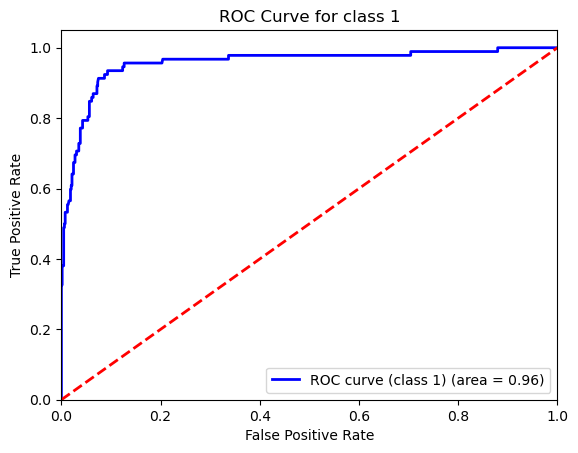

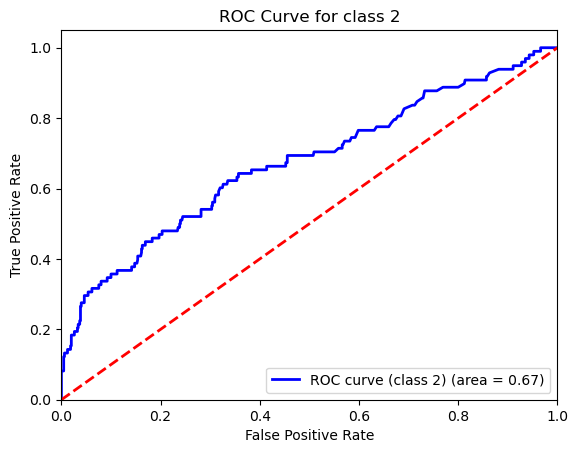

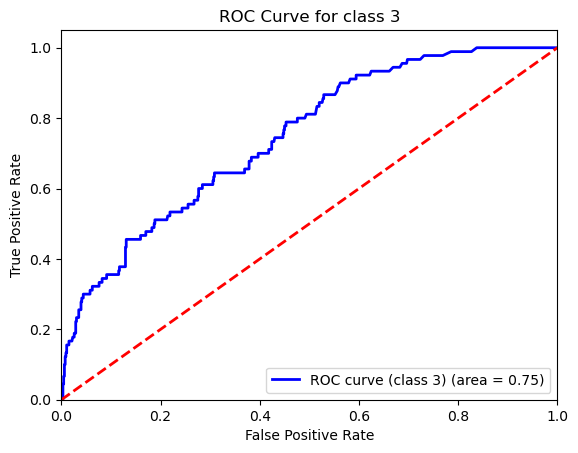

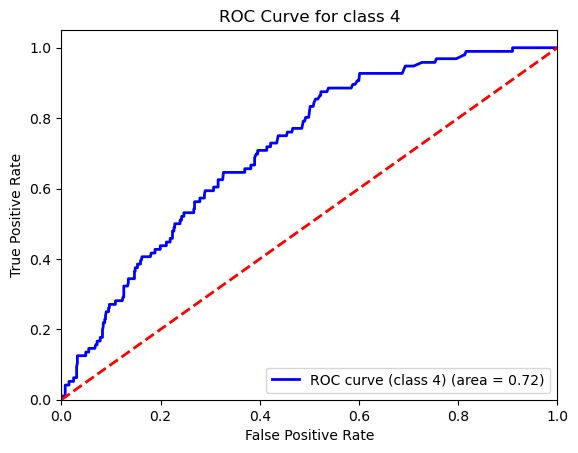

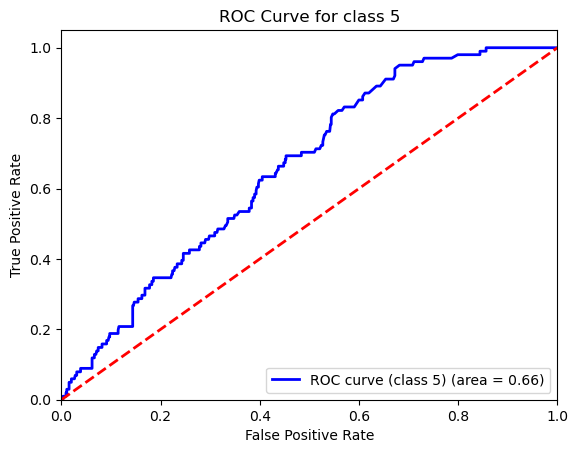

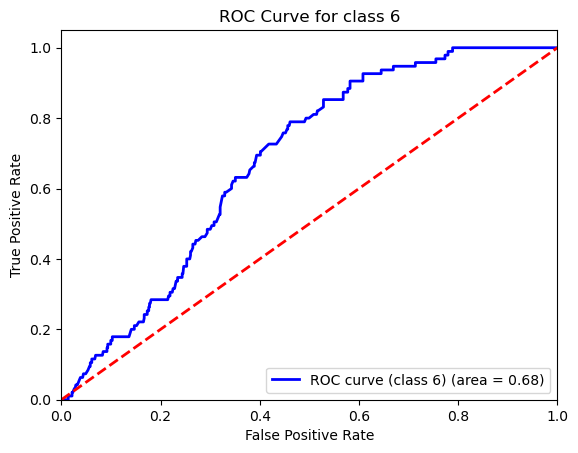

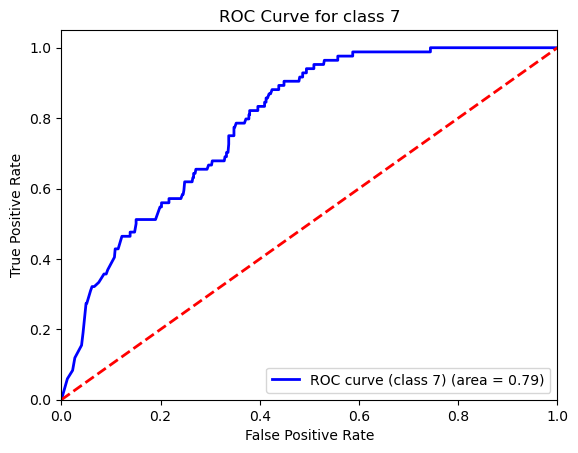

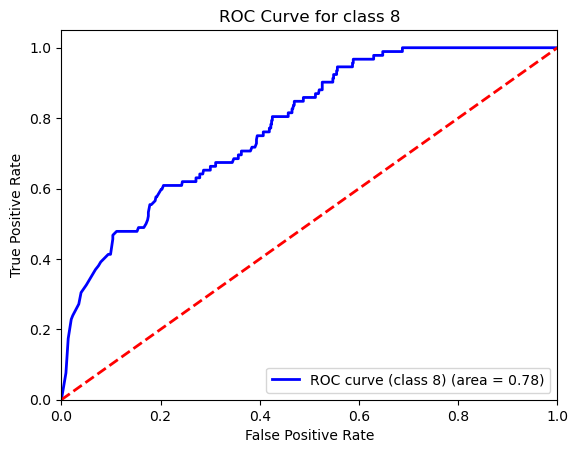

In [55]:
# Curva ROC para cada classe
for i in range(y_train_onehot.shape[1]):  
    fpr, tpr, _ = roc_curve(y_train_onehot[:, i], probabilidades_previstas[:, i])
    roc_auc = auc(fpr, tpr)
    
    # Pegar rótulo real da classe
    classe_real = rótulos_classes[i]  
    
    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (class {classe_real}) (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')  # Linha diagonal para referência
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for class {classe_real}')
    plt.legend(loc="lower right")
    plt.show()


In [57]:
print("Forma de residuos_deviance_val:", residuos_deviance_val.shape)


NameError: name 'residuos_deviance_val' is not defined

In [58]:
# Calcular resíduos deviance
residuos_deviance_val = residuos_deviance(y_train_onehot, probabilidades_previstas)

# Obter rótulos das classes corretamente
rótulos_classes = np.unique(y_train)

# Gerar gráficos de resíduos por classe
for i in range(residuos_deviance_val.shape[1]):  
    plt.figure(figsize=(8, 4))
    plt.scatter(range(len(residuos_deviance_val)), residuos_deviance_val[:, i], 
                label=f'Classe {rótulos_classes[i]}', color='blue')
    plt.axhline(4, color='red', linestyle='--')
    plt.xlabel('Índice da Observação')
    plt.ylabel('Resíduos de Deviance')
    plt.title(f'Resíduos de Deviance para Classe {rótulos_classes[i]}')
    plt.legend()
    plt.show()

C:\Users\gabri\AppData\Local\Temp\ipykernel_1892\3685555478.py:4: RuntimeWarning: divide by zero encountered in log
  deviance_residuals = 2 * (y_true * np.log(y_true / y_pred))
C:\Users\gabri\AppData\Local\Temp\ipykernel_1892\3685555478.py:4: RuntimeWarning: invalid value encountered in multiply
  deviance_residuals = 2 * (y_true * np.log(y_true / y_pred))


IndexError: tuple index out of range

In [49]:
results.params

,0,1,2,3,4,5,6
const,0.455112,-0.381851,0.202752,0.775735,1.103554,2.057098,1.983120
nao_vacinados,-0.094998,-0.093034,-0.111400,-0.115569,-0.131240,-0.171120,-0.174153
vacinados_parcialmente,1.198660,1.075576,0.970519,0.793270,0.660220,0.494277,0.438479
totalmente_vacinados,0.260801,0.383533,0.388842,0.354108,0.336720,0.168887,0.227141


In [59]:
odds_ratio = np.exp(results.params.iloc[1])
print("Razão de chance para o primeiro coeficiente (x1):", odds_ratio)

Razão de chance para o primeiro coeficiente (x1): 0    0.909375
1    0.911163
2    0.894581
3    0.890859
4    0.877007
5    0.842721
6    0.840168
Name: nao_vacinados, dtype: float64


In [51]:
print(results.summary())

                          MNLogit Regression Results                          
Dep. Variable:      idade_agrupamento   No. Observations:                  748
Model:                        MNLogit   Df Residuals:                      720
Method:                           MLE   Df Model:                           21
Date:                Mon, 24 Feb 2025   Pseudo R-squ.:                  0.1916
Time:                        17:34:13   Log-Likelihood:                -1256.6
converged:                       True   LL-Null:                       -1554.4
Covariance Type:            nonrobust   LLR p-value:                1.396e-112
   idade_agrupamento=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.4551      0.356      1.280      0.201      -0.242       1.152
nao_vacinados             -0.0950      0.014     -6.955      0.000      -0.122      -0.068
vaci